In [ ]:
!pip install keras-unet

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras_unet.utils import get_patches
from keras_unet.models import satellite_unet
import glob
import os
from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json

%matplotlib inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
train_image_paths_list = []
train_gt_paths_list = []
train_image_path = '/content/drive/MyDrive/airs-minisample/patch/train/image'
train_label_path = '/content/drive/MyDrive/airs-minisample/patch/train/label'

count = 0
for img_path in glob.glob(os.path.join(train_image_path, '*.tif')):
    train_image_paths_list.append(str(img_path))   
    print(img_path) 
    count += 1
    if count == 100:
      break  
print("Total tif images : ",len(train_image_paths_list))


/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-23.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-24.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-25.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-26.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-27.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-28.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-29.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-30.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-31.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-32.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-33.tif
/content/drive/MyDrive/airs-minisample/patch/train/image/christchurch_97-34.tif
/content/drive/MyDrive/airs-minisample/p

In [ ]:
count = 0
for img_path in glob.glob(os.path.join(train_label_path, '*.tif')):
    train_gt_paths_list.append(str(img_path))
    print(img_path)        
    count += 1
    if count == 100:
      break
print("Total tif images : ",len(train_gt_paths_list))

/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-0.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-1.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-2.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-3.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-4.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-5.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-6.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-7.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-8.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-9.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-10.tif
/content/drive/MyDrive/airs-minisample/patch/train/label/christchurch_97_vis-11.tif
/c

In [ ]:
train_image_paths_list.sort()
train_gt_paths_list.sort()

In [ ]:
train_X = []
train_Y = []
for img in train_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X.append(resized_img)
    
for img in train_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_Y.append(resized_img)
    
print(len(train_X), len(train_Y))

1008 1008


In [ ]:
train_X = np.array(train_X)
train_Y = np.array(train_Y)

train_Y = train_Y.reshape((train_Y.shape[0],train_Y.shape[1],train_Y.shape[2],1))

train_X = train_X / 255.
train_Y = train_Y / 255.

# remove the below line
# train_Y = np.round(train_Y,0)

print(train_X.shape)
print(train_Y.shape)

(1008, 256, 256, 3)
(1008, 256, 256, 1)


In [ ]:
UNetModel = satellite_unet(input_shape=(256, 256, 3))
UNetModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_31 (BatchN  (None, 256, 256, 64  256        ['conv2d_28[0][0]']              
 ormalization)                  )                                                           

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def jacard(y_true, y_pred):

#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum ( y_true_f * y_pred_f)
#     union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

#     return intersection/union


def jaccard(y_true, y_pred):
    """calculate the Jaccard during training and validation
    Args:
    y_true: groundtruth labels
    y_pred: predicted labels
    """

    y_true_f = K.round(K.flatten(y_true))
    y_pred_f = K.round(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    jacc = intersection / (union + K.epsilon())
    return jacc

In [ ]:
def jaccard_index(im1, im2):
    """
    Computes the Jaccard metric, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    jaccard : float
        Jaccard metric returned is a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
    
    Notes
    -----
    The order of inputs for `jaccard` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())

In [ ]:
UNetModel.compile(optimizer='adam', loss='binary_crossentropy', metrics = [jaccard_index, 'accuracy'], run_eagerly=True)

In [ ]:
UNetModel.fit(x=train_X,y=train_Y,batch_size=8,epochs=10,verbose=1)

Epoch 1/10
126/126 [==============================] - 63s 503ms/step - loss: 0.1324 - jaccard_index: 0.1806 - accuracy: 0.9501
Epoch 2/10
126/126 [==============================] - 63s 501ms/step - loss: 0.1295 - jaccard_index: 0.1806 - accuracy: 0.9519
Epoch 3/10
126/126 [==============================] - 63s 502ms/step - loss: 0.1146 - jaccard_index: 0.1806 - accuracy: 0.9572
Epoch 4/10
126/126 [==============================] - 63s 501ms/step - loss: 0.1191 - jaccard_index: 0.1806 - accuracy: 0.9552
Epoch 5/10
126/126 [==============================] - 63s 502ms/step - loss: 0.1083 - jaccard_index: 0.1806 - accuracy: 0.9602
Epoch 6/10
126/126 [==============================] - 63s 501ms/step - loss: 0.1058 - jaccard_index: 0.1806 - accuracy: 0.9605
Epoch 7/10
126/126 [==============================] - 63s 501ms/step - loss: 0.0963 - jaccard_index: 0.1806 - accuracy: 0.9642
Epoch 8/10
126/126 [==============================] - 63s 503ms/step - loss: 0.1044 - jaccard_index: 0.1806 - a

In [ ]:
UNetModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/u-net-1000images-baseline.h5')
UNetModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/u-net-1000images-baseline.tf')

### **Prediction on val image**

In [ ]:
val_image_paths_list = []
val_gt_paths_list = []
val_image_path = '/content/drive/MyDrive/airs-minisample/patch/val/image'
val_label_path = '/content/drive/MyDrive/airs-minisample/patch/val/label'

for img_path in glob.glob(os.path.join(val_image_path, '*.tif')):
    val_image_paths_list.append(str(img_path))        
print("Total tif images : ",len(val_image_paths_list))

for img_path in glob.glob(os.path.join(val_label_path, '*.tif')):
    val_gt_paths_list.append(str(img_path))        
print("Total tif images : ",len(val_gt_paths_list))

val_image_paths_list.sort()
val_gt_paths_list.sort()

Total tif images :  36
Total tif images :  36


In [ ]:
val_X = []
val_Y = []
for img in val_image_paths_list:
    print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_X.append(resized_img)
    
print('*****')
for img in val_gt_paths_list:
    print(img)
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_Y.append(resized_img)
    
print(len(val_X), len(val_Y))

/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-0.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-1.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-10.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-11.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-12.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-13.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-14.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-15.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-16.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-17.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-18.tif
/content/drive/MyDrive/airs-minisample/patch/val/image/christchurch_445-19.tif
/content/drive/MyDrive/airs-minisample/patch/val/image

In [ ]:
val_X = np.array(val_X)
val_Y = np.array(val_Y)

val_Y = val_Y.reshape((val_Y.shape[0],val_Y.shape[1],val_Y.shape[2],1))

val_X = val_X / 255.
val_Y = val_Y / 255.

# val_Y = np.round(val_Y,0)

print(val_X.shape)
print(val_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


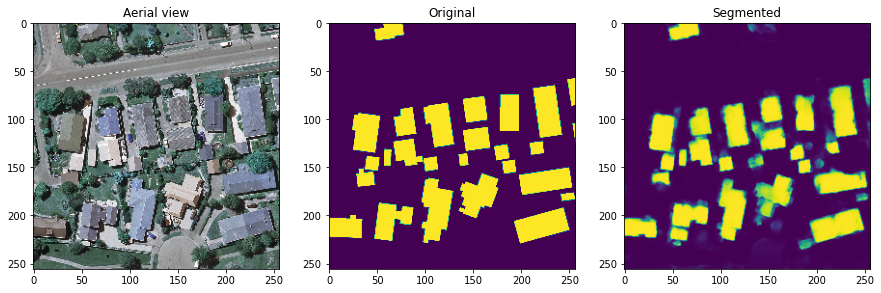

In [ ]:
plt.figure(figsize=(15,15))
pred_y = UNetModel.predict(val_X[16:17])
pred_y = pred_y / 255.
# pred_y = np.round(pred_y,0)

plt.subplot(1,3,1)
plt.imshow(np.squeeze(val_X[16:17]))
plt.title('Aerial view')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(val_Y[16:17]))
plt.title('Original')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred_y[0]))
plt.title('Segmented')

plt.show()

In [ ]:
print(val_Y[16:17][0].shape, pred_y[0].shape)

NameError: ignored

In [ ]:
for i in range(0,34,1):
  print(jaccard_index(val_Y[i:i+1][0], pred_y[0]))

0.27032470703125
0.242767333984375
0.266937255859375
0.1522216796875
0.256866455078125
0.2609405517578125
0.2910308837890625
0.288604736328125
0.28155517578125
0.2711944580078125
0.2567596435546875
0.220550537109375
0.2591705322265625
0.2500457763671875
0.2498931884765625
0.289703369140625
0.2353973388671875
0.2238616943359375
0.2838287353515625
0.2346954345703125
0.2847900390625
0.2896881103515625
0.272003173828125
0.318572998046875
0.279388427734375
0.226715087890625
0.2645263671875
0.278167724609375
0.3105621337890625
0.2582244873046875
0.306671142578125
0.262969970703125
0.32366943359375
0.23834228515625


In [ ]:
from sklearn.metrics import jaccard_score
train_Y[30:31][0].shape, pred_y[0].shape
gt = train_Y[30:31][0]
pred = pred_y[0]
print(gt.shape, pred.shape)
jaccard_index(gt, pred)

(256, 256, 1) (256, 256, 1)


0.2379302978515625

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    MultiResModel = Model(inputs=[inputs], outputs=[conv10])

    return MultiResModel

In [ ]:
MultiResModel = MultiResUnet(height=192, width=256, n_channels=3)
MultiResModel.summary()
MultiResModel.compile(optimizer='adam', loss='binary_crossentropy', metrics = [jaccard_index, 'accuracy'], run_eagerly=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_143 (Conv2D)            (None, 192, 256, 8)  216         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_202 (Batch  (None, 192, 256, 8)  24         ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
epochs = 10
for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        # model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=1, verbose=1)  
        MultiResModel.fit(x=train_X,y=train_Y,batch_size=1,epochs=1,verbose=1)

Epoch : 1


InternalError: ignored